In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [3]:
load_dotenv()

True

In [4]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [6]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="The sentiment of the review")


In [7]:
# defining diagnosis schema
class DiagnosisSchema(BaseModel):
    issues_tupe: Literal["UX", "Performance", "Bug", "Feature Request", "Other"] = Field(description="The type of issue reported in the review")
    tone: Literal["angry", "frustrated", "disappointed", "neutral", "happy"] = Field(description="The tone of the review")
    urgency: Literal["low", "medium", "high"] = Field(description="The urgency of the issue reported in the review")

In [8]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [9]:
prompt = "What is the sentiment of the following review - The software is very good"
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [10]:
# defining state
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['positive', 'neutral', 'negative']
    diagnosis: dict
    response: str
    

In [11]:
# defining sentiment function
def find_sentiment(state: ReviewState):
    
    prompt = f"Find the sentiment for the following sentiment - {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [ ]:
def sentiment_check(state: ReviewState) -> Literal['positive_review', 'neutral_review', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_review'
    elif state['sentiment'] == 'neutral':
        return 'neutral_review'
    else:
        return 'run_diagnosis'

In [13]:
# conditional functions
def positive_review(state: ReviewState):
    prompt = f"Write a thank you response to the following positive review - {state['review']}"
    response = model.invoke(prompt)
    return {"response": response}

def neutral_review(state: ReviewState):
    prompt = f"Write an appreciative response to the following neutral review - {state['review']}"
    response = model.invoke(prompt)
    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"Diagnose the following negative review - {state['review']}\n Return issue_type, tone and urgency in json format"
    response = structured_model2.invoke(prompt)
    return {"diagnosis": response.dict()}

def negative_review(state: ReviewState):
    prompt = f"Write a response to the following negative review - {state['review']}. Address the following issues: {state['diagnosis']}"
    response = model.invoke(prompt)
    return {"response": response}

In [14]:
graph = StateGraph(ReviewState)

# adding nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_review', positive_review)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('neutral_review', neutral_review)
graph.add_node('negative_review', negative_review)


# adding edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", sentiment_check)
graph.add_edge("positive_review", END)
graph.add_edge("neutral_review", END)

graph.add_edge("run_diagnosis", "negative_review")
graph.add_edge("negative_review", END)

# compiling the graph
workflow = graph.compile()

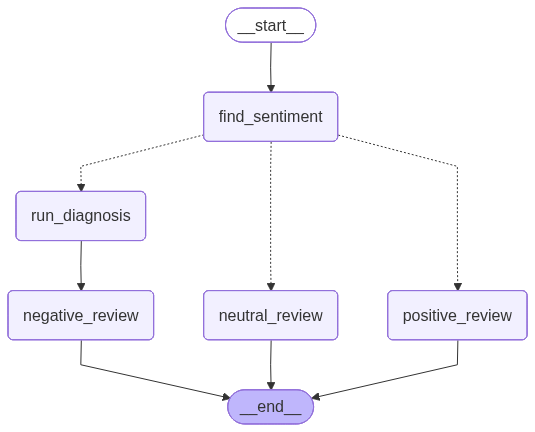

In [15]:
workflow

In [16]:
# defining initial state
initial_state: ReviewState = {
    "review": "I am very disappointed with the performance of the software. It crashes frequently and is very slow.",
    "sentiment": [],
    "diagnosis": {},
    "response": ""
}

In [18]:
workflow.invoke(initial_state)

C:\Users\Sheikh Rakib\AppData\Local\Temp\ipykernel_5732\3843786914.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return {"diagnosis": response.dict()}


{'review': 'I am very disappointed with the performance of the software. It crashes frequently and is very slow.',
 'sentiment': 'negative',
 'diagnosis': {'issues_tupe': 'Performance',
  'tone': 'disappointed',
  'urgency': 'high'},
 'response': AIMessage(content='Dear [Customer Name, if available, otherwise use "Valued Customer" or "Reviewer"],\n\nWe are incredibly sorry to hear about your experience and are genuinely concerned by the issues you\'re facing with our software. Your description of frequent crashes and very slow performance is absolutely unacceptable, and certainly not the reliable experience we aim to provide.\n\nWe understand how incredibly frustrating and disruptive this must be for your workflow, and we sincerely apologize for the disappointment and inconvenience this has caused you.\n\nThis is a high-priority issue for us, and we want to resolve it for you as quickly as possible. To help us diagnose and fix these critical performance problems immediately, please con